## Modelling
For this model architecture, we will use autoencoder to forecast energy usage and then the difference between the forecast and the actual usage if cross a certain treshold are tagged as anomaly. 

### How Autoencoder Works 
An autoencoder consists of two main parts:
- Encoder: This part of the network learns to compress the input data into a lower-dimensional representation or latent space. Essentially, the encoder extracts the most important features of the input.
- Decoder: The decoder attempts to reconstruct the input data from the compressed latent representation. It tries to bring the data back to its original form.

<img src="images/autoencoder.png" alt="Autoencoder" style="width: 600px;"/>

During training, the model is trained to minimize the reconstruction error.

### How LSTM Works
LSTM is specifically designed to solve the vanishing gradient problem of traditional RNNs. It can capture both short-term dependencies (recent data points) and long-term dependencies (older but still relevant data points) in sequences. This is achieved through its unique architecture, which includes three key components:
- Input Gate: Controls how much of the current input to allow into the memory cell.
- Forget Gate: Decides which information from the past should be forgotten or retained.
- Output Gate: Determines how much of the memory cell to pass on as output.

<img src="images/LSTM.jpg" alt="LSTM" style="width: 600px;"/>

### Combining Both
To effectively capture both the temporal dependencies in energy usage data and detect anomalies, we use an LSTM Autoencoder. This combines the sequential learning capabilities of LSTMs with the dimensionality reduction and reconstruction features of autoencoders. Here's how the combined architecture works:

- Encoder: The input sequence of energy usage data (e.g., hourly or daily averages) is passed through LSTM layers in the encoder. These layers compress the input sequence into a latent space representation. The LSTM encoder captures patterns and temporal relationships in the data.
- Latent Space: The encoder reduces the input data into a lower-dimensional representation that retains only the most critical information, discarding noise and redundant features.
- Decoder: The latent representation is passed to the LSTM decoder, which attempts to reconstruct the input sequence. This step uses the compressed representation to recreate the original energy usage pattern.
- Reconstruction Error: The reconstructed sequence is compared to the original input sequence, and the difference is calculated as the reconstruction error.
For normal data, the error is low because the model has learned the regular patterns. For anomalies, the reconstruction error is significantly higher, as the model cannot effectively recreate these unseen patterns.

Source (https://doi.org/10.1016/j.ijinfomgt.2020.102282)

<img src="images/LSTM Autoencoder.jpg" alt="LSTM" style="width: 600px;"/>

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import save_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/conv_data.csv')

In [3]:
features = ['hour', 'day_of_week']
X = data[features]

In [4]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [6]:
X_train.shape[1]

2

In [7]:
input_dim = X_train.shape[1]

In [8]:
# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

# Decoder
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder Model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(), loss=MeanSquaredError())

In [9]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1005 - val_loss: 0.0896
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0799 - val_loss: 0.0654
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0619 - val_loss: 0.0423
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0328 - val_loss: 0.0099
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 12/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_lo

In [10]:
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


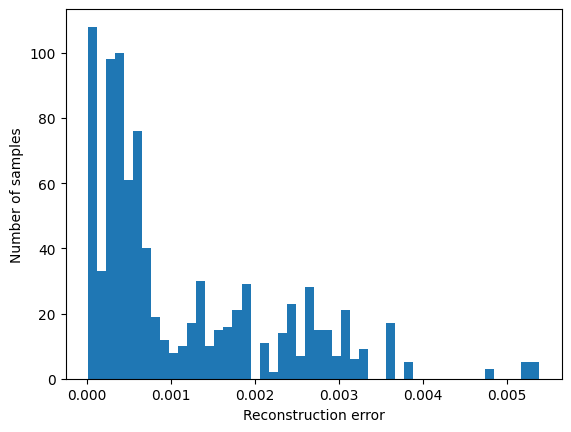

In [11]:
# Visualize reconstruction errors
plt.hist(reconstruction_error, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Number of samples')
plt.show()

In [12]:
threshold = np.percentile(reconstruction_error, 99)  # Adjust based on tolerance

In [13]:
data['reconstruction_error'] = np.nan
data.loc[X_test_indices := data.index[len(X_train):], 'reconstruction_error'] = reconstruction_error
data['anomaly'] = data['reconstruction_error'] > threshold

In [14]:
anomalous_data = data[data['anomaly']]

for index, row in anomalous_data.iterrows():
    print(row.to_dict())

{'timestamp': '2024-07-29 13:00:00', 'hourly average': 39763848.66666666, 'usage': 14.108354166666048, 'hour': 13, 'day_of_week': 0, 'reconstruction_error': 0.005263187028583971, 'anomaly': True}
{'timestamp': '2024-07-31 05:00:00', 'hourly average': 40081213.833333336, 'usage': 0.2248333333358168, 'hour': 5, 'day_of_week': 2, 'reconstruction_error': 0.005384791900726715, 'anomaly': True}
{'timestamp': '2024-08-05 12:00:00', 'hourly average': 40721118.0, 'usage': 14.9955, 'hour': 12, 'day_of_week': 0, 'reconstruction_error': 0.005384791900726715, 'anomaly': True}
{'timestamp': '2024-08-05 19:00:00', 'hourly average': 40805670.5, 'usage': 0.19775, 'hour': 19, 'day_of_week': 0, 'reconstruction_error': 0.005384791900726715, 'anomaly': True}
{'timestamp': '2024-08-10 07:00:00', 'hourly average': 41179147.833333336, 'usage': 0.2042333333343267, 'hour': 7, 'day_of_week': 5, 'reconstruction_error': 0.005263187028583971, 'anomaly': True}
{'timestamp': '2024-08-16 10:00:00', 'hourly average': 4

In [16]:
autoencoder.save("autoencoder_model.h5")
print("Model saved as autoencoder_model.h5")

Model saved as autoencoder_model.h5
